In [1]:
from policies import Trajectory, p_s_from_rollouts, p_sa_from_rollouts, sr_from_rollouts, average_reward_from_rollouts, sa_sr_from_rollouts, sa_sr_from_rollouts_1
from aggregation import get_aggregator
from plotting import plot_heatmap
import aggregation
import pickle
import scipy

def read_pickle(save_name):
    """
    Thread-safe pickle read.
    Safe even if other threads are simultaneously calling dump_pickle()
    on the same file.
    """
    with open(save_name, "rb") as f:
        return pickle.load(f)
    

runs_e = read_pickle("out/mc_lowbins_1/eigenoptions/part0_runs.pkl")
runs_c  =read_pickle("out/mc_lowbins_1/codex/part0_runs.pkl")
params = read_pickle("out/mc_lowbins_1/params.pkl")

In [2]:



params
base_args = params['args_codex'][0]


In [7]:

def plots_p_sa_from_run(base_args, run):
    s_agg, sa_agg = get_aggregator(base_args["env_name"]) 

    epochs=len(run)
    
    for i in range(epochs):

        transitions = run[i]["all_rollouts"]
        p_sa = p_sa_from_rollouts(transitions, sa_agg)




        plot_heatmap(p_sa.reshape(12, -1))


def plots_sr_from_run(base_args, run):
    s_agg, sa_agg = get_aggregator(base_args["env_name"])

    epochs=len(run)
    
    for i in range(epochs):

        transitions = run[i]["all_rollouts"][0]
        print(type(transitions))
        SR = sa_sr_from_rollouts_1(transitions, sa_agg)
        SR = SR.toarray()




        plot_heatmap(SR)

        

# plots_p_sa_from_run(base_args, runs_e[0])
plots_sr_from_run(base_args, runs_e[0])



<class 'policies.Trajectory'>


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Untyped global name 'sa_agg': Cannot determine Numba type of <class 'aggregation.SA_Aggregator'>

File "policies.py", line 408:
def average_reward_from_rollouts(rollouts, reward_fn = None):
    <source elided>

import itertools
^

During: Pass nopython_type_inference 

This error may have been caused by the following argument(s):
- argument 0: Cannot determine Numba type of <class 'scipy.sparse._lil.lil_matrix'>


In [38]:
l1_eig = read_pickle("out/mc_lowbins_1/codex/all_l1_covs.pkl")
l1_cov = read_pickle("out/mc_lowbins_1/eigenoptions/all_l1_covs.pkl")


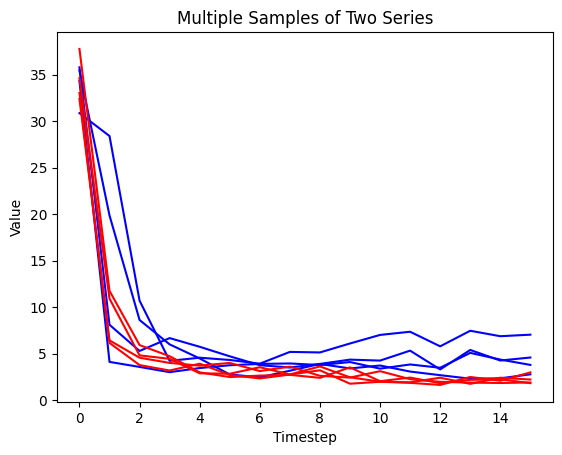

In [39]:
import matplotlib.pyplot as plt
import numpy as np

def plot_competing(runs1, runs2):
    timesteps = np.arange(len(runs1[0]))
    for sample in runs1:
        plt.plot(timesteps, sample, color="blue", alpha=1)

    for sample in runs2:
        plt.plot(timesteps, sample, color="red", alpha=1)

    plt.xlabel("Timestep")
    plt.ylabel("Value")
    plt.title("Multiple Samples of Two Series")
    plt.show()

plot_competing(l1_eig, l1_cov)

In [40]:
def competing_timesteps(timesteps, values1_samples, values2_samples,
                        label1="Values 1", label2="Values 2"):
    """
    Plot two sets of sample trajectories (list of lists) as:
      - solid mean lines
      - 95% confidence interval shaded regions

    Parameters
    ----------
    timesteps : list or array
        Shared timesteps.
    values1_samples : list of lists
        Samples for series 1.
    values2_samples : list of lists
        Samples for series 2.
    label1 : str
        Label for the first series.
    label2 : str
        Label for the second series.
    """

    def mean_and_ci(samples):
        arr = np.array(samples)  # (n_samples, n_timesteps)
        mean = arr.mean(axis=0)
        sem  = stats.sem(arr, axis=0)
        ci   = 1.96 * sem
        return mean, mean - ci, mean + ci

    # Compute stats
    mean1, low1, high1 = mean_and_ci(values1_samples)
    mean2, low2, high2 = mean_and_ci(values2_samples)

    # Plot
    plt.figure(figsize=(10, 6))

    plt.plot(timesteps, mean1, label=label1, linewidth=2)
    plt.fill_between(timesteps, low1, high1, alpha=0.3)

    plt.plot(timesteps, mean2, label=label2, linewidth=2)
    plt.fill_between(timesteps, low2, high2, alpha=0.3)

    plt.xlabel("Timestep")
    plt.ylabel("Value")
    plt.title("Competing Timesteps with 95% Confidence Intervals")
    plt.legend()
    plt.grid(True)
    plt.show()

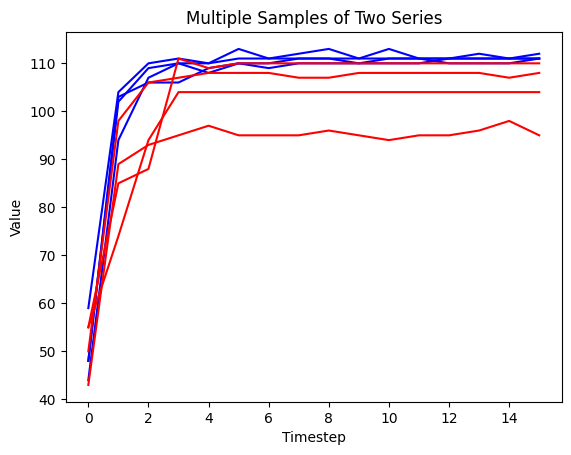

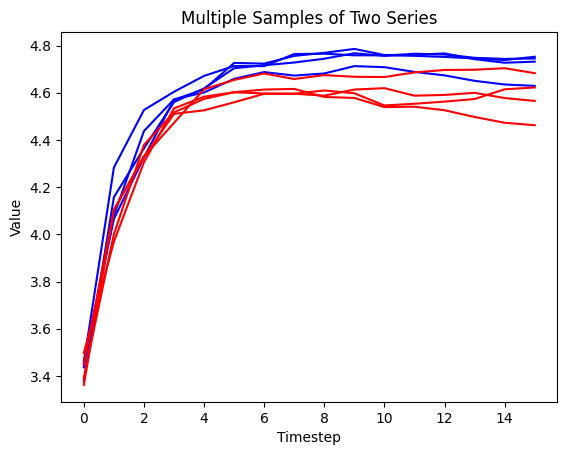

In [42]:
def entropy_from_run(base_args, run):
    s_agg, sa_agg = get_aggregator(base_args["env_name"]) 

    entropies = []

    for epoch in run:
        transitions = epoch["all_rollouts"]
        p_sa = p_sa_from_rollouts(transitions,sa_agg)
        entropies.append(scipy.stats.entropy(p_sa.flatten()))

    return  entropies
        
    



def unique_states_visited_from_run(base_args, run):
    s_agg, sa_agg = get_aggregator(base_args["env_name"]) 

    usv = []

    for epoch in run:
        transitions = epoch["all_rollouts"]
        p_sa = p_s_from_rollouts(transitions,s_agg)

        usv.append(np.count_nonzero(p_sa))


    return  usv

usv_e = [unique_states_visited_from_run(base_args, run) for run in runs_e]
ent_e = [entropy_from_run(base_args, run) for run in runs_e]

usv_c = [unique_states_visited_from_run(base_args, run) for run in runs_c]
ent_c = [entropy_from_run(base_args, run) for run in runs_c]
plot_competing(usv_e, usv_c)
plot_competing(ent_e, ent_c)

In [10]:
print(ent_c)

[[array([[       nan,        nan,        nan],
       [       nan,        nan,        nan],
       [1.43034983, 1.04375704, 0.95604438],
       [1.28996414, 1.32384272, 1.33873859],
       [1.21469702, 1.17951837, 1.22400115],
       [1.07476789, 1.09739539, 1.09384358],
       [1.2091519 , 1.20855418, 1.24396477],
       [1.34331051, 1.34913731, 1.32992617],
       [1.18826065, 1.07952957, 1.13699432],
       [       nan,        nan,        nan],
       [       nan,        nan,        nan]]), array([[1.57037283, 1.71312666, 1.5969196 ],
       [1.89057351, 1.64779247, 2.00399827],
       [1.95610685, 1.82623779, 2.05624503],
       [2.02739128, 1.99770467, 1.88954473],
       [1.47602144, 1.48016371, 1.62206917],
       [1.26840218, 1.2686857 , 1.44544497],
       [1.50314106, 1.66656264, 1.90709464],
       [2.04803937, 2.11554176, 2.24633821],
       [2.03780273, 2.12319759, 2.06466948],
       [2.10439944, 1.9636206 , 2.12198253],
       [1.8512651 , 1.82231421, 1.77569718]]), arra